In [1]:
# import cProfile
import collections
import datetime
import math

import os
# import sys
import time

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, RobustScaler

import random

import gc

pd.options.display.float_format = "{:.2f}".format
# plt.rcParams.update({'font.size': 18})
format = '%d/%m/%Y %H:%M'

# Load data

Load all data required.

In [2]:
def load_file(data_path, msg):
    if msg != '':
        txt = msg + ' - ' + data_path
    else:
        txt = data_path

    if os.path.exists(data_path):
        print('Loaded: ' + txt)
        with open(data_path, 'rb') as f:
            file_loaded = pickle.load(f)
        return file_loaded
    else:
        print('File not found: ' + txt)

In [3]:
# Load all data

playlists_train = load_file(
    os.getcwd() + '\\data\\processed\\3_playlists_dict_train.pkl',
    'Playlists dictionary (training)')
playlists_test = load_file(
    os.getcwd() + '\\data\\processed\\3_playlists_dict_test.pkl',
    'Playlists dictionary (test)')
print('Playlist - training set: ' + str(len(playlists_train)))
print('Playlist - test set: ' + str(len(playlists_test)))
print()

tracks_dict_train = load_file(
    os.getcwd() + '\\data\\processed\\4_tracks_dict_train.pkl',
    'Tracks dictionary (training)')
tracks_dict_test = load_file(
    os.getcwd() + '\\data\\processed\\4_tracks_dict_test.pkl',
    'Tracks dictionary (test)')
print('Tracks - training set: ' + str(len(tracks_dict_train)))
print('Tracks - test set: ' + str(len(tracks_dict_test)))
print()

artists_dict_train = load_file(
    os.getcwd() + '\\data\\processed\\5_artists_dict_train.pkl',
    'Artist dictionary (training)')
artists_dict_test = load_file(
    os.getcwd() + '\\data\\processed\\5_artists_dict_test.pkl',
    'Artist dictionary (test)')
print('Artist - training set: ' + str(len(artists_dict_train)))
print('Artist - test set: ' + str(len(artists_dict_test)))
print()

albums_dict_train = load_file(
    os.getcwd() + '\\data\\processed\\6_albums_dict_train.pkl',
    'Albums dictionary (training)')
albums_dict_test = load_file(
    os.getcwd() + '\\data\\processed\\6_albums_dict_test.pkl',
    'Albums dictionary (test)')
print('Albums - training set: ' + str(len(albums_dict_train)))
print('Albums - test set: ' + str(len(albums_dict_test)))
print()

Loaded: Playlists dictionary (training) - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\3_playlists_dict_train.pkl
Loaded: Playlists dictionary (test) - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\3_playlists_dict_test.pkl
Playlist - training set: 1243
Playlist - test set: 533

Loaded: Tracks dictionary (training) - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\4_tracks_dict_train.pkl
Loaded: Tracks dictionary (test) - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\4_tracks_dict_test.pkl
Tracks - training set: 63699
Tracks - test set: 31183

Loaded: Artist dictionary (training) - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\5_artists_dict_train.pkl
Loaded: Artist dictionary (test) - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\5_artists_dict_test.pkl
Artist - training set: 22639
Artist - test set: 12780

Loaded: Albums dictionary

In [131]:
data_path = os.getcwd() + '\\data\\processed\\4_tracks_dict.pkl'
txt = 'All tracks as a dictionary - ' + data_path

if os.path.exists(data_path):
    print('Loaded: ' + txt)
    with open(data_path, 'rb') as f:
        tracks_dict = pickle.load(f)
else:
#     print('File not found: ' + txt)
    tracks_dict = dict_all_tracks(data_path,playlists_dict)

print(len(tracks_dict))

Loaded: All tracks as a dictionary - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\4_tracks_dict.pkl
85458


##### Create data frames to perform analysis

In [4]:
gc.collect()
df_playlists_train = playlists_train.T
print("df_playlists_train:", df_playlists_train.shape)

df_playlists_test = playlists_test.T
print("df_playlists_test:", df_playlists_test.shape)

df_tracks_train = pd.DataFrame.from_dict(tracks_dict_train, orient='index')
df_tracks_train = df_tracks_train.T
print("df_tracks_train:", df_tracks_train.shape)

df_tracks_test = pd.DataFrame.from_dict(tracks_dict_test, orient='index')
df_tracks_test = df_tracks_test.T
print("df_tracks_test:", df_tracks_test.shape)

df_artists_train = pd.DataFrame.from_dict(artists_dict_train, orient='index')
df_artists_train = df_artists_train.T
print("df_artists_train:", df_artists_train.shape)

df_artists_test = pd.DataFrame.from_dict(artists_dict_test, orient='index')
df_artists_test = df_artists_test.T
print("df_artists_test:", df_artists_test.shape)

df_albums_train = pd.DataFrame.from_dict(albums_dict_train, orient='index')
df_albums_train = df_albums_train.T
print("df_albums_train:", df_albums_train.shape)

df_albums_test = pd.DataFrame.from_dict(albums_dict_test, orient='index')
df_albums_test = df_albums_test.T
print("df_albums_test:", df_albums_test.shape)

df_playlists_train: (4, 1243)
df_playlists_test: (4, 533)
df_tracks_train: (7, 63699)
df_tracks_test: (7, 31183)
df_artists_train: (3, 22639)
df_artists_test: (3, 12780)
df_albums_train: (4, 46688)
df_albums_test: (4, 24258)


# Co-occurrence matrix

## Tracks co-occurrence matrix

In [5]:
def co_occurrence_matrix_tracks(playlists_dict, tracks_dict):
    matrix = {}
    for i, item in enumerate(tracks_dict):
        tracks_matched = []
        for j, playlist_id in enumerate(tracks_dict[item]['in_playlist']):
            for tr, track in enumerate(playlists_dict[playlist_id]['tracks']):
                tracks_matched.append(track['id'])
        counter = collections.Counter(tracks_matched)
        b = pd.DataFrame.from_dict(counter, orient='index', columns=['cnt'])
        b = b.sort_values('cnt', ascending=False)

        min_max = MinMaxScaler()
        b['count_scaled'] = min_max.fit_transform(b[['cnt']])
        b['rank'] = b['count_scaled'].rank(method='average', ascending=False)

        matrix.update({item: b})
    return (matrix)

## Artists co-occurrence matrix

In [6]:
def co_occurrence_matrix_artists(playlists_dict, artists_dict):
    matrix = {}
    for i, item in enumerate(artists_dict):
        artist_matched = []
        for j, playlist_id in enumerate(artists_dict[item]['in_playlist']):
            for tr, track in enumerate(playlists_dict[playlist_id]['tracks']):
                for a, artist in enumerate(track['artists']):
                    artist_matched.append(artist['id'])
        counter = collections.Counter(artist_matched)
        b = pd.DataFrame.from_dict(counter, orient='index', columns=['cnt'])
        b = b.sort_values('cnt', ascending=False)

        min_max = MinMaxScaler()
        b['count_scaled'] = min_max.fit_transform(b[['cnt']])
        b['rank'] = b['count_scaled'].rank(method='average', ascending=False)

        matrix.update({item: b})
    return (matrix)

## Albums co-occurrence matrix

In [7]:
def co_occurrence_matrix_albums(playlists_dict, albums_dict):
    matrix = {}
    for i, item in enumerate(albums_dict):
        albums_matched = []
        for j, playlist_id in enumerate(albums_dict[item]['in_playlist']):
            for tr, track in enumerate(playlists_dict[playlist_id]['tracks']):
                albums_matched.append(track['album']['id'])
        counter = collections.Counter(albums_matched)
        b = pd.DataFrame.from_dict(counter, orient='index', columns=['cnt'])
        b = b.sort_values('cnt', ascending=False)

        min_max = MinMaxScaler()
        b['count_scaled'] = min_max.fit_transform(b[["cnt"]])
        b["rank"] = b['count_scaled'].rank(method='average', ascending=False)

        matrix.update({item: b})
    return (matrix)

##  Create all co-ocurrence matrix

In [8]:
def co_ocurrence(playlist, df, data_path, txt):
    # check if data extraction already exists then load if it exists, otherwise run query
    if os.path.exists(data_path):
        print('Co-occurrence ' + txt + ' - Loaded: ' + data_path)
        # load file only if the next step was not executed (getting tracks)
        with open(data_path, 'rb') as f:
            co_occurrence = pickle.load(f)
    else:
        print('Co-occurrence ' + txt + ' - Saved: ' + data_path)
        # list of all user ids (UID) and playlist ids (PID)
        uid_pid_raw = []

        if txt == 'tracks':
            co_occurrence = co_occurrence_matrix_tracks(playlist, df)
        elif txt == 'artists':
            co_occurrence = co_occurrence_matrix_artists(playlist, df)
        elif txt == 'albums':
            co_occurrence = co_occurrence_matrix_albums(playlist, df)

        # Save the data
        with open(data_path, 'wb') as f:
            pickle.dump(co_occurrence, f)

    len(co_occurrence)
    # co_occurrence_tracks['1MJ5f5EYBC92ADD6xcz7nb']
    return co_occurrence

In [9]:
gc.collect()

co_occurrence_tracks_train = co_ocurrence(
    df_playlists_train, df_tracks_train,
    os.getcwd() + '\\data\\processed\\7_co_occurrence_tracks_train.pkl',
    'tracks')
# co_occurrence_tracks_test = co_ocurrence(
#     df_playlists_test, df_tracks_test,
#     os.getcwd() + '\\data\\processed\\7_co_occurrence_tracks_test.pkl',
#     'tracks')

co_occurrence_artists_train = co_ocurrence(
    df_playlists_train, df_artists_train,
    os.getcwd() + '\\data\\processed\\7_co_occurrence_artists_train.pkl',
    'artists')
# co_occurrence_artists_test = co_ocurrence(
#     df_playlists_test, df_artists_test,
#     os.getcwd() + '\\data\\processed\\7_co_occurrence_artists_test.pkl',
#     'artists')

co_occurrence_albums_train = co_ocurrence(
    df_playlists_train, df_albums_train,
    os.getcwd() + '\\data\\processed\\7_co_occurrence_albums_train.pkl',
    'albums')
# co_occurrence_albums_test = co_ocurrence(
#     df_playlists_test, df_albums_test,
#     os.getcwd() + '\\data\\processed\\7_co_occurrence_albums_test.pkl',
#     'albums')

print("co_occurrence_tracks_train:", len(co_occurrence_tracks_train))
# print("co_occurrence_tracks_test:", len(co_occurrence_tracks_test))
print("co_occurrence_artists_train:", len(co_occurrence_artists_train))
# print("co_occurrence_artists_test:", len(co_occurrence_artists_test)
print("co_occurrence_albums_train:", len(co_occurrence_albums_train))
# print("co_occurrence_albums_test:", len(co_occurrence_albums_test))

Co-occurrence tracks - Loaded: C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\7_co_occurrence_tracks_train.pkl
Co-occurrence artists - Loaded: C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\7_co_occurrence_artists_train.pkl
Co-occurrence albums - Loaded: C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\7_co_occurrence_albums_train.pkl
co_occurrence_tracks_train: 63699
co_occurrence_artists_train: 22639
co_occurrence_albums_train: 46688


# Model

In [77]:
def prepare_inputs(playlist_trx, trx_train, trx_test, fraction):
    trx = playlist_trx.tracks
    n = int((len(trx) + 1) * fraction)

    ids = pd.DataFrame(trx).id  # ids of the original playlist
    selected_ids = random.sample(ids.values.tolist(), n)

    db = trx_train.T
    trx_available = db[~db.id.isin(selected_ids)]

    reference_trx = trx_test.T[trx_test.T.id.isin(selected_ids)]
    expected_trx = trx_test.T[~trx_test.T.id.isin(selected_ids)
                              & trx_test.T.id.isin(ids)]

    return trx_available, reference_trx, expected_trx

## Random

In [11]:
def get_trk_rnd(playlist_trx, trx_train, trx_test, ref_fraction):
    trx_available, reference_trx, expected_trx = prepare_inputs(playlist_trx, trx_train, trx_test, ref_fraction)
        
    select = random.sample(trx_available['id'].values.tolist(), len(expected_trx))
    
    selected_trx = trx_available[trx_available.id.isin(select)]

    return reference_trx, expected_trx, selected_trx

# reference_trx, expected_trx, selected_trx = get_trk_rnd(
#     df_playlists_test['1h4bUPnrpgn8qXGJ5dvTsu'], df_tracks_train,
#     df_tracks_test, .5)
# print(len(reference_trx), len(expected_trx), len(selected_trx))
# reference_trx, expected_trx, selected_trx

## Stratified selection

In [12]:
# Calculate the tracks frequency
def define_trx_freq(db):
    data_path = os.getcwd() + '\\data\\processed\\8_tracks_frequency.pkl'
    txt = 'Tracks frequency - ' + data_path
    if os.path.exists(data_path):
        print('Loaded: ' + txt)
        with open(data_path, 'rb') as f:
            tracks_frequency = pickle.load(f)
            return tracks_frequency
    else:
        tracks_frequency = pd.DataFrame(
            columns=['track_id', 'cnt', 'cum_sum', 'cum_perc'])

        for t, trk in enumerate(db):
            if t % 100 == 0:
                print("%s - %d/%d - LEN: %d" %
                      (datetime.datetime.now().strftime(format), t, len(db),
                       len(tracks_frequency)))

            df = db[trk]
            df = df[df.index != trk]
            tracks_frequency = tracks_frequency.append(
                {
                    'track_id': trk,
                    'cnt': df['cnt'].sum()
                }, ignore_index=True)

        tracks_frequency = tracks_frequency.sort_values(ascending=False,
                                                        by='cnt')
        tracks_frequency['cum_sum'] = tracks_frequency['cnt'].cumsum()
        tracks_frequency['cum_perc'] = 100 * tracks_frequency[
            'cum_sum'] / tracks_frequency['cnt'].sum()

        print('Saved: ' + txt)
        with open(data_path, 'wb') as f:
            pickle.dump(tracks_frequency, f)

        return tracks_frequency

In [13]:
tracks_frequency = define_trx_freq(co_occurrence_tracks_train)
print(len(tracks_frequency))

Loaded: Tracks frequency - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\8_tracks_frequency.pkl
63699


In [99]:
def get_trk_strata(playlist_trx, trx_train, trx_test, ref_fraction):
    trx_available, reference_trx, expected_trx = prepare_inputs(playlist_trx, trx_train, trx_test, ref_fraction)
    
    trx_freq = tracks_frequency[tracks_frequency.track_id.isin(trx_available['id'])]
    
    select = trx_freq.drop(trx_freq.index)

    while len(select) < len(expected_trx)*2:
        rnd = random.uniform(0, 1)
        for i, c in enumerate(trx_freq.cum_perc):
            if rnd <= c:
                select = select.append(trx_freq.iloc[i])
                select = select.drop_duplicates()
                break
    
    select = select[~select.track_id.isin(reference_trx['id'])]
    select = select.reset_index()
    select = select.iloc[0:len(expected_trx)]['track_id']
    
    selected_trx = trx_available[trx_available.id.isin(select)]
    
    return reference_trx, expected_trx, selected_trx

# reference_trx, expected_trx, selected_trx = get_trk_strata(
#     df_playlists_test['1h4bUPnrpgn8qXGJ5dvTsu'], df_tracks_train,
#     df_tracks_test, .5)
# print(len(reference_trx), len(expected_trx), len(selected_trx))
# reference_trx, expected_trx, selected_trx

## Artist

In [ ]:
# prepare_inputs_co_occur
# def prepare_inputs_co_occur(playlist_trx, trx_train, trx_test, fraction):
#     trx = playlist_trx.tracks
#     n = int((len(trx) + 1) * fraction)

#     ids = pd.DataFrame(trx).id  # ids of the original playlist
#     selected_ids = random.sample(ids.values.tolist(), n)

#     db = trx_train.T
#     trx_available = db[~db.id.isin(selected_ids)]

#     reference_trx = trx_test.T[trx_test.T.id.isin(selected_ids)]
#     expected_trx = trx_test.T[~trx_test.T.id.isin(selected_ids)
#                               & trx_test.T.id.isin(ids)]

#     return trx_available, reference_trx, expected_trx

In [101]:
def get_trk_artist(playlist_trx, trx_train, trx_test, ref_fraction):
    trx_available, reference_trx, expected_trx = prepare_inputs(playlist_trx, trx_train, trx_test, ref_fraction)
    
    trx_freq = tracks_frequency[tracks_frequency.track_id.isin(trx_available['id'])]
    
    select = trx_freq.drop(trx_freq.index)

    ballot = 
    
    
    while len(select) < len(expected_trx)*2:
        rnd = random.uniform(0, 1)
        for i, c in enumerate(ballot.cum_perc):
            if rnd <= c:
                select = select.append(trx_freq.iloc[i])
                select = select.drop_duplicates()
                break
    
    select = select[~select.track_id.isin(reference_trx['id'])]
    select = select.reset_index()
    select = select.iloc[0:len(expected_trx)]['track_id']
    
    selected_trx = trx_available[trx_available.id.isin(select)]
    
    return reference_trx, expected_trx, selected_trx

reference_trx, expected_trx, selected_trx = get_trk_artist(
    df_playlists_test['1h4bUPnrpgn8qXGJ5dvTsu'], df_tracks_train,
    df_tracks_test, .5)
print(len(reference_trx), len(expected_trx), len(selected_trx))
# reference_trx, expected_trx, selected_trx

50 50 50


In [102]:
trx_available, reference_trx, expected_trx = prepare_inputs(df_playlists_test['1h4bUPnrpgn8qXGJ5dvTsu'], df_tracks_train, df_tracks_test, .5)

len(trx_available), len(reference_trx), len(expected_trx)

# reference_trx, expected_trx, selected_trx = get_trk_strata(
#             df_playlists_test['1h4bUPnrpgn8qXGJ5dvTsu'], df_tracks_train, df_tracks_test,
#             .5)

(63653, 50, 50)

In [103]:
reference_trx

,id,name,added_at,popularity,artists,album,in_playlist
08bNPGLD8AhKpnnERrAc6G,08bNPGLD8AhKpnnERrAc6G,FRIENDS,2019-04-05T20:25:08Z,80,"[{'id': '64KEffDW9EtZ1y2vBYgq8T', 'name': 'Mar...","{'id': '1BmxOYHjQv1dKZRr13YRZM', 'name': 'FRIE...","[1h4bUPnrpgn8qXGJ5dvTsu, 0qtzSPz2ZwC21sWdlEEos..."
45Egmo7icyopuzJN0oMEdk,45Egmo7icyopuzJN0oMEdk,Love Lies (with Normani),2020-05-02T23:01:55Z,76,"[{'id': '6LuN9FCkKOj5PcnpouEgny', 'name': 'Kha...","{'id': '4CEAev7neETRdqBFtzA8B9', 'name': 'Love...","[1h4bUPnrpgn8qXGJ5dvTsu, 4UJ9uTJatHD4isU6JjC9B..."
3ee8Jmje8o58CHK66QrVC2,3ee8Jmje8o58CHK66QrVC2,SAD!,2021-11-17T08:06:33Z,86,"[{'id': '15UsOTVnJzReFVN1VCnxy4', 'name': 'XXX...","{'id': '2Ti79nwTsont5ZHfdxIzAm', 'name': '?', ...","[1h4bUPnrpgn8qXGJ5dvTsu, 5MLvN0gvJ4CfJxcNFRIkR..."
3Vo4wInECJQuz9BIBMOu8i,3Vo4wInECJQuz9BIBMOu8i,Finesse - Remix; feat. Cardi B,2018-08-01T18:12:24Z,75,"[{'id': '0du5cEVh5yTK9QJze8zA0C', 'name': 'Bru...","{'id': '3mumK2ar9b4JPhVOZR0V2p', 'name': 'Fine...","[1h4bUPnrpgn8qXGJ5dvTsu, 4jhz41YA4LCLAzWXFX15k..."
7dt6x5M1jzdTEt8oCbisTK,7dt6x5M1jzdTEt8oCbisTK,Better Now,2021-08-24T19:59:57Z,82,"[{'id': '246dkjvS1zLTtiykXe5h60', 'name': 'Pos...","{'id': '6trNtQUgC8cgbWcqoMYkOR', 'name': 'beer...","[1h4bUPnrpgn8qXGJ5dvTsu, 4UJ9uTJatHD4isU6JjC9B..."
3NLnwwAQbbFKcEcV8hDItk,3NLnwwAQbbFKcEcV8hDItk,Perfect,2021-03-15T18:33:04Z,78,"[{'id': '4AK6F7OLvEQ5QYCBNiQWHq', 'name': 'One...","{'id': '1gMxiQQSg5zeu4htBosASY', 'name': 'Made...","[1h4bUPnrpgn8qXGJ5dvTsu, 6ZN6dlzC9EMlveIhG7N9B..."
6DCZcSspjsKoFjzjrWoCdn,6DCZcSspjsKoFjzjrWoCdn,God's Plan,2021-02-07T16:49:10Z,83,"[{'id': '3TVXtAsR1Inumwj472S9r4', 'name': 'Dra...","{'id': '1ATL5GLyefJaxhQzSPVrLX', 'name': 'Scor...","[1h4bUPnrpgn8qXGJ5dvTsu, 6ELUs1QqubzhS8WtZfe55..."
3Q3myFA7q4Op95DOpHplaY,3Q3myFA7q4Op95DOpHplaY,do re mi,2020-09-22T19:50:17Z,43,"[{'id': '2cFrymmkijnjDg9SS92EPM', 'name': 'bla...","{'id': '30QoUTsSdpQuZunPNFsLnm', 'name': 'digi...","[1h4bUPnrpgn8qXGJ5dvTsu, 2rMSK78e2ck6Z3R6SCMxaY]"
1rfofaqEpACxVEHIZBJe6W,1rfofaqEpACxVEHIZBJe6W,Havana (feat. Young Thug),2021-11-12T08:58:07Z,82,"[{'id': '4nDoRrQiYLoBzwC5BhVJzF', 'name': 'Cam...","{'id': '2vD3zSQr8hNlg0obNel4TE', 'name': 'Cami...","[1h4bUPnrpgn8qXGJ5dvTsu, 1Lzr0Hx5uXKs9R9WRzME2..."
1UZOjK1BwmwWU14Erba9CZ,1UZOjK1BwmwWU14Erba9CZ,Malibu,2019-01-16T15:28:04Z,75,"[{'id': '5YGY8feqx7naU7z4HrwZM6', 'name': 'Mil...","{'id': '5xG9gJcs9ut3qDWezHUlsX', 'name': 'Youn...","[1h4bUPnrpgn8qXGJ5dvTsu, 4OwLvyFX0jlmRZNBhJ8X2P]"


In [123]:
co_occurrence_artists_train.head()

AttributeError: 'dict' object has no attribute 'head'

In [ ]:
trk

In [130]:
for t, trk in enumerate(reference_trx['id']):
    if t == 0:
        print(trk)
#         print(reference_trx.T[trk].artists)
        for a in reference_trx.T[trk].artists:
            print(a)
            print(a['id'])
#             co_occurrence_artists_train[a.id]
            

08bNPGLD8AhKpnnERrAc6G
{'id': '64KEffDW9EtZ1y2vBYgq8T', 'name': 'Marshmello', 'in_playlist': ['2dbL1KoWphbT4uZKOgnnKw', '36gUYaCXYmKJ5FQCjRGXOm', '4jwLkSVrnathscvWtxy1Fa', '3NWlcmwxDe3viSgLh0Uyan', '2y4snt2vxFnEBKzeYfVCEj', '3o0YWwdt1uNsb27RsMF1NP', '0x8L3xUxvSyIMRYnYkiV0t', '0x8L3xUxvSyIMRYnYkiV0t', '0x8L3xUxvSyIMRYnYkiV0t', '0WlA8Y3FUV12uEFTqdjX5h', '0WlA8Y3FUV12uEFTqdjX5h', '1TD0LTMfEnlGUdWwXPnHH7', '6oBdDSGRarIXfnaENeezML', '6oBdDSGRarIXfnaENeezML', '2y55MTtGfZV6GcvZ6a3ZKM', '2y55MTtGfZV6GcvZ6a3ZKM', '29OMQ9a5Teg3DLDIBE9pL4', '0XodjwYYVOz9VPBJRvaQdj', '0XodjwYYVOz9VPBJRvaQdj', '08OatoWvxf9XWIGKLCHmw0', '0XbIRrKGcTrHnjZ8548dtp', '0XbIRrKGcTrHnjZ8548dtp', '7vYF2UuSJtA6ErtAutUe4j', '7vYF2UuSJtA6ErtAutUe4j', '27HlKfzMohMjVPuYYbRgka', '27HlKfzMohMjVPuYYbRgka', '1ZZWyjlXlF8Y0I8q4WzRvy', '1ZZWyjlXlF8Y0I8q4WzRvy', '1ZZWyjlXlF8Y0I8q4WzRvy', '6HIHUzISZdwDtu2MRrGlDF', '6HIHUzISZdwDtu2MRrGlDF', '6HIHUzISZdwDtu2MRrGlDF', '6HIHUzISZdwDtu2MRrGlDF', '6HIHUzISZdwDtu2MRrGlDF', '6HIHUzISZdwDtu2MRrGlD

## Album

In [18]:
def get_trk_album(playlist_trx, trx_train, trx_test, ref_fraction):
    trx_available, reference_trx, expected_trx = prepare_inputs(playlist_trx, trx_train, trx_test, ref_fraction)
        
    select = random.sample(trx_available['id'].values.tolist(), len(expected_trx))
    
    selected_trx = trx_available[trx_available.id.isin(select)]

    return reference_trx, expected_trx, selected_trx


reference_trx, expected_trx, selected_trx = get_trk_album(
    df_playlists_test['1h4bUPnrpgn8qXGJ5dvTsu'], df_tracks_train,
    df_tracks_test, .5)
print(len(reference_trx), len(expected_trx), len(selected_trx))
# reference_trx, expected_trx, selected_trx

50 50 50


## Track

In [19]:
def get_trk_track(playlist_trx, trx_train, trx_test, ref_fraction):
    trx_available, reference_trx, expected_trx = prepare_inputs(playlist_trx, trx_train, trx_test, ref_fraction)
        
    select = random.sample(trx_available['id'].values.tolist(), len(expected_trx))
    
    selected_trx = trx_available[trx_available.id.isin(select)]

    return reference_trx, expected_trx, selected_trx


reference_trx, expected_trx, selected_trx = get_trk_track(
    df_playlists_test['1h4bUPnrpgn8qXGJ5dvTsu'], df_tracks_train,
    df_tracks_test, .5)
print(len(reference_trx), len(expected_trx), len(selected_trx))
# reference_trx, expected_trx, selected_trx

50 50 50


# Evaluate models

In [20]:
def get_trk(method, reference, ref_fraction):
    if method == 'random':
        reference_trx, expected_trx, selected_trx = get_trk_rnd(
            df_playlists_test[reference], df_tracks_train, df_tracks_test,
            ref_fraction)
    elif method == 'strata':
        reference_trx, expected_trx, selected_trx = get_trk_strata(
            df_playlists_test[reference], df_tracks_train, df_tracks_test,
            ref_fraction)
    elif method == 'artist':
        reference_trx, expected_trx, selected_trx = get_trk_artist(
            df_playlists_test[reference], df_tracks_train, df_tracks_test,
            ref_fraction)
    elif method == 'album':
        reference_trx, expected_trx, selected_trx = get_trk_album(
            df_playlists_test[reference], df_tracks_train, df_tracks_test,
            ref_fraction)
    elif method == 'playlist':
        reference_trx, expected_trx, selected_trx = get_trk_track(
            df_playlists_test[reference], df_tracks_train, df_tracks_test,
            ref_fraction)

    return reference_trx, expected_trx, selected_trx

In [21]:
methods = ['random', 'strata', 'artist', 'album', 'playlist']
splits = [.25, .5, .75]

In [96]:
methods = ['random', 'strata']
splits = [.5]

In [97]:
results = pd.DataFrame(columns=[
    'playlist', 'method', 'frac', 'total_tracks', 'selected_tracks', 'matches',
    'error'
])

a = df_playlists_test
for m, method in enumerate(methods):
    print(method)
    for f, frac in enumerate(splits):
        print(frac)
        for p, playlist in enumerate(a):
            if p % 100 == 0:
                print("%s - %d/%d - LEN: %d" % (datetime.datetime.now().strftime(format), p, len(a.T), len(results)))
            #                 if p == 0:
            #                 print(p)
            #                 print(df_playlists_test[playlist])
            #                 print(type(df_playlists_test[playlist]))
            #                 print(df_playlists_test[playlist])
            reference_trx, expected_trx, selected_trx = get_trk(
            method, playlist, frac)

            matches = len(selected_trx[selected_trx.id.isin(expected_trx.id)].id)
            total_trx = a[playlist].total_tracks
            error = 1 - matches / a[playlist].total_tracks
            sel_trx = len(selected_trx)

            results = results.append(
            {
            'playlist': playlist,
            'method': method,
            'frac': frac,
            'total_tracks': total_trx,
            'selected_tracks': sel_trx,
            'matches': matches,
            'error': error
            },
            ignore_index=True)

results.set_index('playlist', inplace=True)
# print(len(reference_trx), len(expected_trx), len(selected_trx))

random
0.5
14/05/2022 13:23 - 0/533 - LEN: 0
14/05/2022 13:23 - 100/533 - LEN: 100
14/05/2022 13:23 - 200/533 - LEN: 200
14/05/2022 13:24 - 300/533 - LEN: 300
14/05/2022 13:24 - 400/533 - LEN: 400
14/05/2022 13:24 - 500/533 - LEN: 500
strata
0.5
14/05/2022 13:24 - 0/533 - LEN: 533
14/05/2022 13:26 - 100/533 - LEN: 633
14/05/2022 13:27 - 200/533 - LEN: 733
14/05/2022 13:28 - 300/533 - LEN: 833
14/05/2022 13:29 - 400/533 - LEN: 933
14/05/2022 13:31 - 500/533 - LEN: 1033


In [ ]:
results

In [ ]:
summ = results['matches'].describe()
summ

In [ ]:
# profiling_grid['performance_ratio'] = profiling_grid['accuracy']/profiling_grid['run_time']
# profiling_grid['run_time_mean'] = profiling_grid.groupby('classifier')['run_time'].transform('mean')
# profiling_grid['accuracy_mean'] = profiling_grid.groupby('classifier')['accuracy'].transform('mean')
# profiling_grid['performance_average'] = profiling_grid.groupby('classifier')['performance_ratio'].transform('mean')
# profiling_grid['rank_overall'] = profiling_grid['performance_ratio'].rank(method='dense', ascending=False)
# profiling_grid['rank_average'] = profiling_grid['performance_average'].rank(method='dense', ascending=False)

In [ ]:
# def visualize_all_box(df, group):
#     rows = math.ceil(math.sqrt(len(df.keys()) - 1))
#     cols = math.floor(math.sqrt(len(df.keys()) - 1))

#     fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(20, 15))
#     fig.suptitle('Boxplot of each method split and fraction recommended')

#     i = 0
#     for method in df.keys():
#         i = i + 1

#         r = int((i - 1) / cols)
#         c = i - r * cols - 1
#         print(r, c)
#         sns.boxplot(ax=axes[r, c],
#                     data=df,
#                     x=group,
#                     y=matches,
#                     hue=group,
#                     palette='summer_r',
#                     showmeans=True,
#                     meanprops={
#                         "marker": "o",
#                         "markerfacecolor": "red",
#                         "markeredgecolor": "red"
#                     },
#                     flierprops=dict(marker='.',
#                                     markerfacecolor='steelblue',
#                                     markeredgecolor='steelblue',
#                                     alpha=.5),
#                     boxprops=dict(alpha=.7),
#                     width=.5,
#                     notch=True).set_title(method)

# #         for line in axes[r, c].get_lines()[6::7]:
# #             #                 line.set_mec('purple') # to test that we have the correct Line2Ds
# #             offsets = line.get_xdata()
# #             #                 print(y)
# #             line.set_xdata(offsets +
# #                            np.random.uniform(-0.05, 0.05, offsets.size))

#         axes[r, c].legend(loc='upper center',
#                           title=method,
#                           frameon=False,
#                           ncol=2)
#         axes[r, c].set_xticklabels(['25%', '50%', '75%'])
#     plt.subplots_adjust(left=0.1,
#                         bottom=0.1,
#                         right=0.9,
#                         top=0.9,
#                         wspace=0.15,
#                         hspace=0.25)
#     plt.show()


# visualize_all_box(results, 'frac')

# # Statistical summary of the numerical columns
# summ = results.describe().transpose()
# summ

## Results visualization

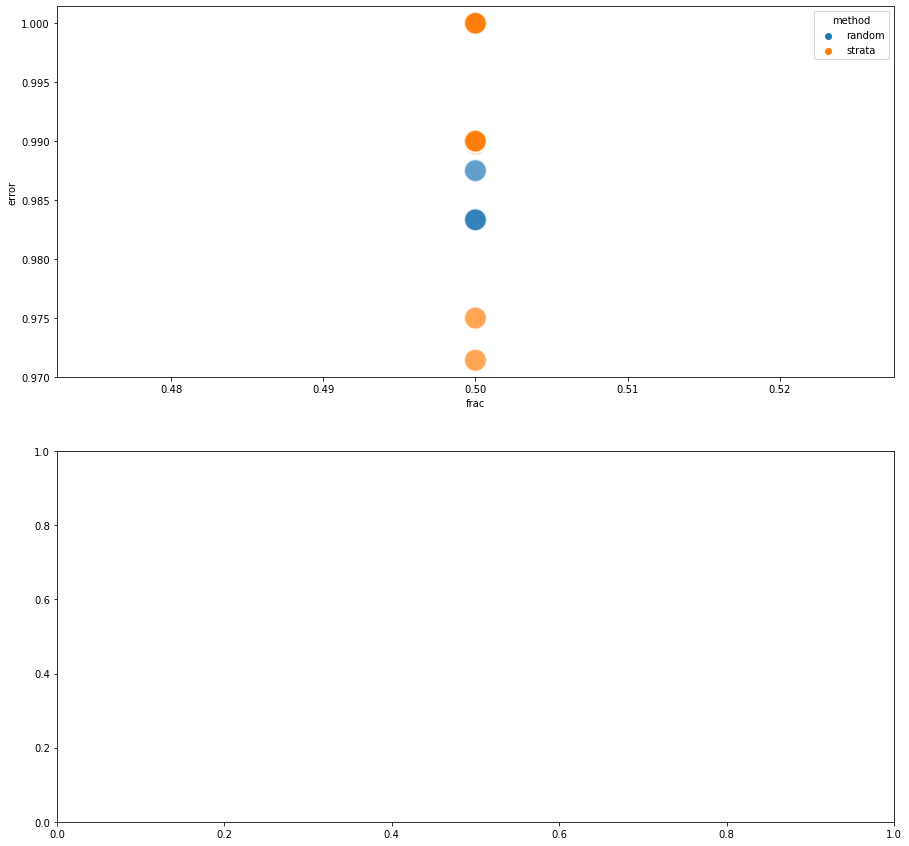

In [98]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(15, 15))
sns.scatterplot(ax=axes[0], x='frac', y='error', data=results, s=500, alpha =0.7, hue='method');
# plt.y_label('Run time') #y label

# sns.scatterplot(ax=axes[1], x='run_time_mean', y='accuracy_mean', data=profiling_grid, s=500, alpha =0.7, hue='classifier');
# plt.xlabel('Mean run time') #y label
# plt.ylabel('Mean accuracy') #x label
# plt.grid()
plt.rcParams['axes.grid'] = True

#  Tests

In [ ]:
# expected_trx

In [ ]:
# selected_trx

In [ ]:
# # reference_trx, expected_trx, 
# selected_trx = selected_trx.append(expected_trx[expected_trx['id'] == '0e3CM2Fm4cpDtxjzYkdLAr'])

# matches = selected_trx[selected_trx.id.isin(expected_trx.id)].id
# matches
# len(matches)

In [ ]:
# selected_trx.info()

In [ ]:
# for t, tid in enumerate(co_occurrence_tracks_train):
#     if t == 10:
#         df = co_occurrence_tracks_train[tid]
#         df['cum_sum'] = df['cnt'].cumsum()
#         df['cum_perc'] = 100*df['cum_sum']/df['cnt'].sum()
#         selector = random.sample(list(df.index),len(df))
#         print(selector)
#         print(len(selector))

#         cnt = 0
#         tot = 0
#         for i, item in enumerate(co_occurrence_tracks_train[tid]['cnt']):
#                 cnt = cnt + 1
#                 tot = tot + item
#         print(cnt)
#         print(tot)

In [ ]:
# def ranking(df,id_column):
#     single_list_temp = single_list(df[id_column])
#     data = {id_column: single_list_temp}
#     aux_df = pd.DataFrame(data)
    
#     name = id_column.replace('_id','_count')
#     ranked_sorted = aux_df.groupby([id_column]).agg(
#         temp_count=pd.NamedAgg(column=id_column, aggfunc="count")
#     )
#     ranked_sorted = ranked_sorted.rename(columns={'temp_count': name})
#     ranked_sorted = ranked_sorted.sort_values(name,ascending=False)
#     return ranked_sorted
# # ranking(df_test,'tracks_id')
# # print(tracks_rank)

# def top(ranked,n):
#     top_n = ranked.iloc[:n]
    
#     return top_n
# # tracks_rank = ranking(df_test,'tracks_id')
# # top(tracks_rank,10)
#     return ranked

# a = track_rank = ranking(df_test,'tracks_id')

In [ ]:
# df['cum_sum'] = df['cnt'].cumsum()
# df['cum_perc'] = 100*df['cum_sum']/co_occurrence_tracks_train['cnt'].sum()

In [ ]:
# matrix track x track
# track_rank = ranking(df_test,'tracks_id')
# s_tracks_id = list(track_rank.index)

# shape = [len(s_tracks_id), len(s_tracks_id)]
# track_matrix = np.zeros(shape, dtype=int, order='C')

# for i, row_track in enumerate(s_tracks_id):
#     row = s_tracks_id.index(row_track)
#     if i != row: print("i: " + str(i) + ": " + row_track), print()

#     for playlist in df_test['tracks_id']:
#         try:
#             check = playlist.index(row_track)
#         except ValueError:
#             #             print(row)
#             check = -1
#         if check >= 0:
#             for col_track in playlist:
#                 if col_track is not None:
#                     col = s_tracks_id.index(col_track)
#                     #                     print(col_track  + " - " + str(col))
#                     #                     tr = df_test['tracks'][n][col]
#                     #                     print("track: " + str(n) + ": " + col_track + " - col_match:" + str(col) + ": ") # + tr)
#                     track_matrix[row, col] += 1
# # print(track_matrix)